## Final Project Submission

* Student name: Matthew Lipman
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: Amber Yandow
* Blog post URL:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import haversine as hs #geographic distance calculator

## Load and prepare data

In [2]:
df_train = pd.read_csv('data/kc_house_data.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [4]:
#locations pulled from scientology-seattle.org
church_of_scientology_mission = (47.818100, -122.315430)
church_of_scientology_washington = (47.622380, -122.361020)
church_of_scientology_life_improvement_center = (47.615060, -122.327580)

In [5]:
#function that identifies the distance between a point of interest and house 
def distance_to(point_of_interest):
    distance = df_train[['lat','long']].apply(lambda x: hs.haversine(x.tolist(), point_of_interest), axis=1)
    return distance

In [6]:
#creating new columns of distances from houses to point of interest
df_train['distance_to_scientology_m'] = distance_to(church_of_scientology_mission)
df_train['distance_to_scientology_w'] = distance_to(church_of_scientology_washington)
df_train['distance_to_scientology_l'] = distance_to(church_of_scientology_life_improvement_center)
df_train['closest_distance_to_scientology'] = df_train[['distance_to_scientology_m',
                                                        'distance_to_scientology_w',
                                                        'distance_to_scientology_l']].min(axis=1)

In [7]:
#creating categorical variable 'is_close' to signify houses that are less than 10 km from a church of scientology
df_train['is_close'] = np.where(df_train['closest_distance_to_scientology'] < 10, 1, 0)

In [8]:
#creating a price per square foot column
df_train['ppsqft'] = df_train['price'] / df_train['sqft_living']

Distribution appears to deviate slightly from a normal distribution.
Displays a positive skewness.
Skewness: 1.2469211620378835
Kurtosis: 2.0993152010383684
n= 21597


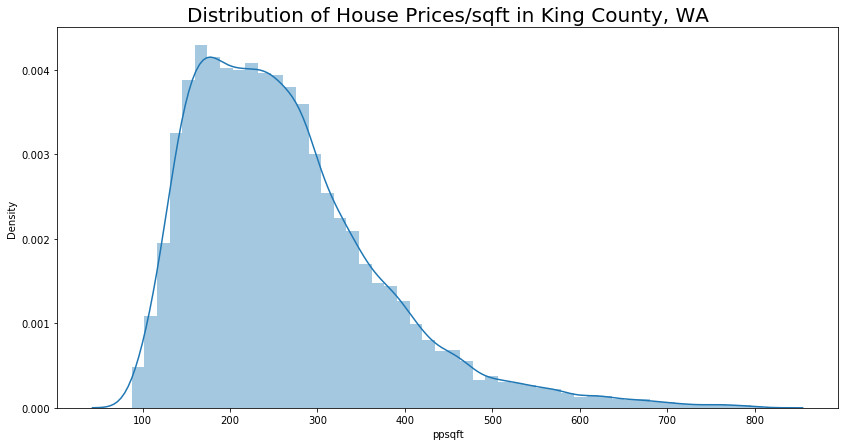

In [9]:
plt.figure(figsize=(14,7))
sns.distplot(df_train['ppsqft'])
plt.title("Distribution of House Prices/sqft in King County, WA", fontsize=20);
print("Distribution appears to deviate slightly from a normal distribution.")
print("Displays a positive skewness.")
print("Skewness:", df_train['ppsqft'].skew())
print("Kurtosis:", df_train['ppsqft'].kurt())
print("n=",len(df_train['ppsqft']))

In [10]:
#Remove unwanted columns
drop_vars = ['date', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated',
             'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
             'bedrooms', 'bathrooms', 'floors', 'sqft_lot', 'waterfront',
             'condition', 'yr_built', 'distance_to_scientology_m', 'distance_to_scientology_w',
             'distance_to_scientology_l', 'id']
df_mvp = df_train.drop(columns=drop_vars)

## Cleaning the data (outliers and transformations)

In [11]:
#standardizing data 'price'
price_scaled = StandardScaler().fit_transform(df_mvp['price'][:,np.newaxis]);
low_range = price_scaled[price_scaled[:,0].argsort()][:10]
high_range= price_scaled[price_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.25843051]
 [-1.25298626]
 [-1.25026413]
 [-1.247542  ]
 [-1.24618094]
 [-1.24481987]
 [-1.24209774]
 [-1.23937562]
 [-1.23937562]
 [-1.23529242]]

outer range (high) of the distribution:
[[10.75159884]
 [10.77882013]
 [11.24158191]
 [12.43931829]
 [12.95652264]
 [13.09262905]
 [13.69149724]
 [17.28470638]
 [17.74746817]
 [19.48963018]]


>**Comment:** The high range of the distribution have relatively larger outliers than the low range of the outliers. The largest high range prices on the distribution are over 10 standard deviations from the mean.

In [12]:
#standardizing data 'ppsqft'
price_scaled = StandardScaler().fit_transform(df_mvp['ppsqft'][:,np.newaxis]);
low_range = price_scaled[price_scaled[:,0].argsort()][:10]
high_range= price_scaled[price_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.60508294]
 [-1.60454817]
 [-1.60394587]
 [-1.60133954]
 [-1.60108345]
 [-1.60057861]
 [-1.59997324]
 [-1.59641519]
 [-1.59641519]
 [-1.59498821]]

outer range (high) of the distribution:
[[4.74958004]
 [4.75368624]
 [4.77583808]
 [4.78804419]
 [4.79577473]
 [4.79976206]
 [4.80501367]
 [4.85446151]
 [4.87153402]
 [4.96370782]]


>**Comment:** The high range of the distribution have relatively larger outliers than the low range of the outliers. The largest high range prices on the distribution are over 4 standard deviations from the mean, but less than 5 standard deviations.

In [13]:
#removing rows with house prices per square foot over 1x standard deviations from mean
df_no_outlier = df_mvp[(np.abs(stats.zscore(df_mvp['ppsqft'])) < 1.5)]
#df_no_outlier = df_mvp[(np.abs(stats.zscore(df_no_outlier)) < 1).all(axis=1)]
print("I have removed all outliers that are more than three standard deviations outside of the mean. I have removed a total number of", len(df_mvp)-len(df_no_outlier), "rows.")

I have removed all outliers that are more than three standard deviations outside of the mean. I have removed a total number of 1812 rows.


In [14]:
df_no_outlier = df_mvp[(np.abs(stats.zscore(df_mvp)) < 3).all(axis=1)]
print("I have removed all outliers that are more than three standard deviations outside of the mean. I have removed a total number of", len(df_mvp)-len(df_no_outlier), "rows.")

I have removed all outliers that are more than three standard deviations outside of the mean. I have removed a total number of 953 rows.


In [15]:
len(df_mvp)

21597

In [16]:
len(df_no_outlier)

20644

Distribution displays a positive skew.
Skewness: 0.8174169192762071
Kurtosis: 0.433372742347057


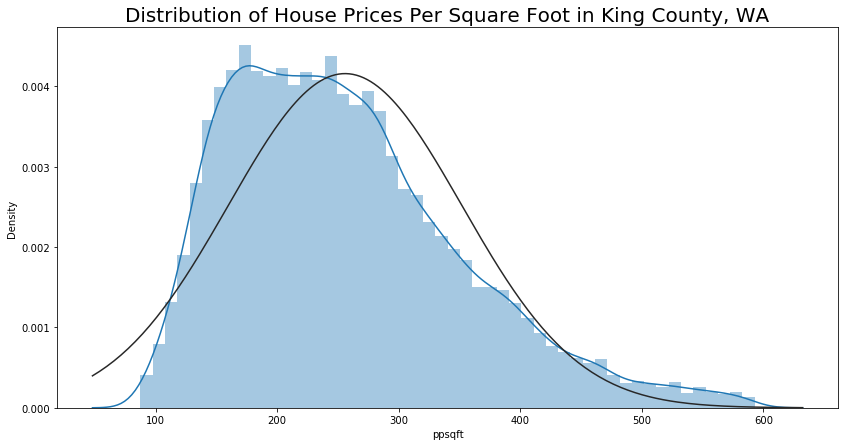

In [17]:
plt.figure(figsize=(14,7))
sns.distplot(df_no_outlier['ppsqft'], fit=norm)
plt.title("Distribution of House Prices Per Square Foot in King County, WA", fontsize=20);
print("Distribution displays a positive skew.")
print("Skewness:", df_no_outlier['ppsqft'].skew())
print("Kurtosis:", df_no_outlier['ppsqft'].kurt())

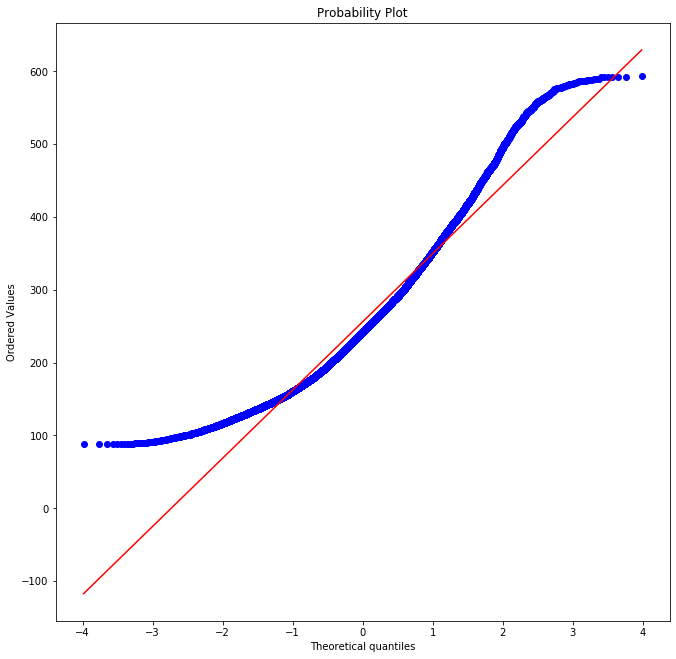

In [18]:
fig = plt.figure(figsize=(11,11))
res = stats.probplot(df_no_outlier['ppsqft'], plot=plt)

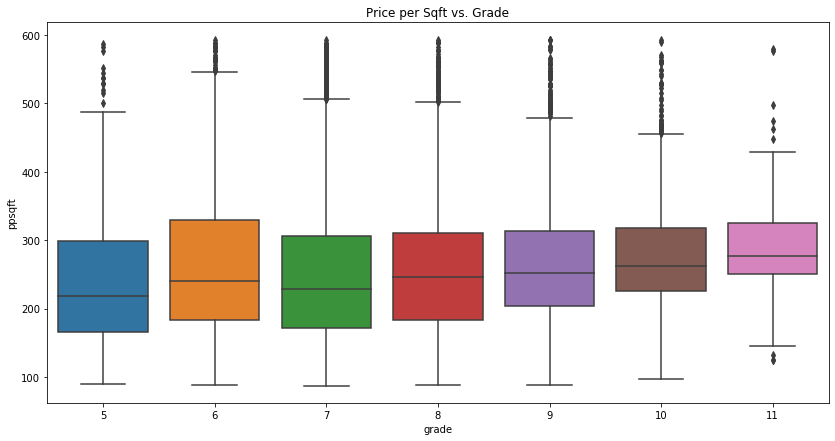

In [19]:
#grade
plot1 = pd.concat([df_no_outlier['ppsqft'], df_no_outlier['grade']], axis=1)
f, ax = plt.subplots(figsize=(14, 7))
fig = sns.boxplot(x='grade', y='ppsqft', data=plot1)
plt.title("Price per Sqft vs. Grade");

In [20]:
#applying log transformation to 'price'
#df_no_outlier['price_log'] = np.log(df_no_outlier['price'])

In [21]:
#visualizing the normalization of 'price'
#sns.distplot(df_no_outlier['price_log'], fit=norm);
#fig = plt.figure()
#res = stats.probplot(df_no_outlier['price_log'], plot=plt)

In [22]:
#histogram and normal probability plot
#plt.figure(figsize=(14,7))
#sns.distplot(df_no_outlier['sqft_living'], fit=norm)
#plt.title("Distribution of Square Footage of Houses in King County, WA", fontsize=20);
#print("Distribution displays a positive skew.")
#print("Skewness:", df_no_outlier['price'].skew())
#print("Kurtosis:", df_no_outlier['price'].kurt())

In [23]:
#applying log transformation to 'sqft_living'
#df_no_outlier['sqft_living_log'] = np.log(df_no_outlier['sqft_living'])

In [24]:
#visualizing the normalization of 'sqft_living'
#sns.distplot(df_no_outlier['sqft_living_log'], fit=norm);
#fig = plt.figure()
#res = stats.probplot(df_no_outlier['sqft_living_log'], plot=plt)

Distribution does not appear to be normally distributed.
Skewness: 1.352971240359586
Kurtosis: 2.317557236153612


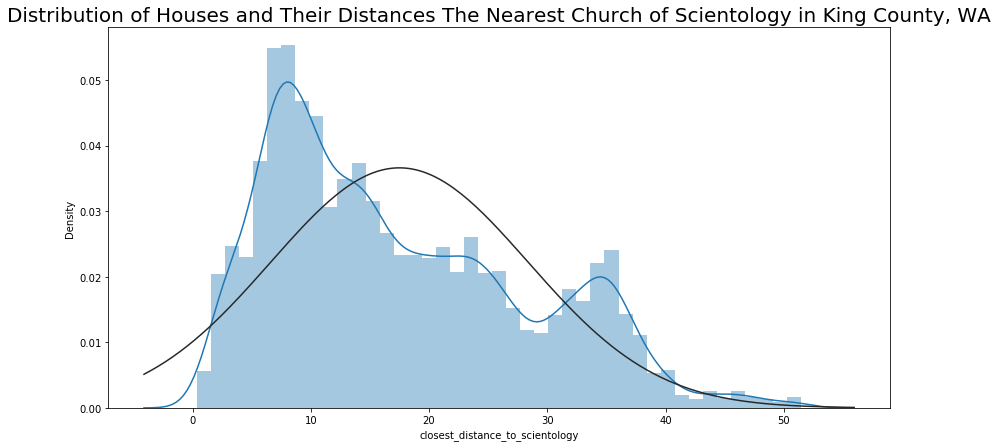

In [25]:
#histogram and normal probability plot
plt.figure(figsize=(14,7))
sns.distplot(df_no_outlier['closest_distance_to_scientology'], fit=norm)
plt.title("Distribution of Houses and Their Distances The Nearest Church of Scientology in King County, WA", fontsize=20);
print("Distribution does not appear to be normally distributed.")
print("Skewness:", df_no_outlier['price'].skew())
print("Kurtosis:", df_no_outlier['price'].kurt())

In [26]:
#data transformation
df_no_outlier['scientology_log'] = np.log(df_no_outlier['closest_distance_to_scientology'])

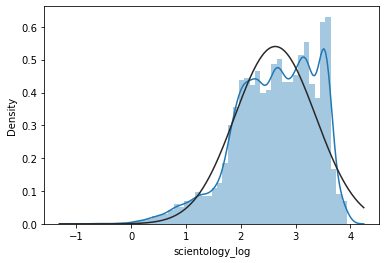

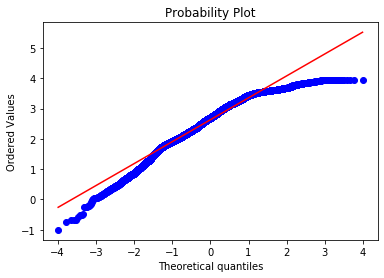

In [27]:
#transformed histogram and normal probability plot
sns.distplot(df_no_outlier['scientology_log'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_no_outlier['scientology_log'], plot=plt)

In [28]:
# Convert categorical variables (df_no_outlier[['grade', 'is_close']]) into dummy variables
df_no_outlier = pd.get_dummies(df_no_outlier)

## Identifying the model data

In [29]:
#Remove unwanted columns
drop_vars = ['price', 'sqft_living', 'closest_distance_to_scientology']
df_train_mvp = df_no_outlier.drop(columns=drop_vars)

In [30]:
df_train_mvp.head()

,grade,is_close,ppsqft,scientology_log
0,7,0,188.050847,2.541998
1,7,0,209.338521,2.379577
2,6,0,233.766234,2.383079
3,7,0,308.163265,2.446441
4,8,0,303.571429,3.053153


In [31]:
# Fitting the model
outcome = 'price_log'
x_cols = ['sqft_living_log']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_train_mvp).fit()
model.summary()

PatsyError: Error evaluating factor: NameError: name 'sqft_living_log' is not defined
    price_log~sqft_living_log
              ^^^^^^^^^^^^^^^

In [32]:
# Fitting the model
outcome = 'price_log'
x_cols = ['sqft_living_log', 'scientology_log']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_train_mvp).fit()
model.summary()

PatsyError: Error evaluating factor: NameError: name 'sqft_living_log' is not defined
    price_log~sqft_living_log+scientology_log
              ^^^^^^^^^^^^^^^

In [33]:
# Fitting the model
outcome = 'price_log'
x_cols = ['sqft_living_log', 'scientology_log', 'grade']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df_train_mvp).fit()
model.summary()

PatsyError: Error evaluating factor: NameError: name 'sqft_living_log' is not defined
    price_log~sqft_living_log+scientology_log+grade
              ^^^^^^^^^^^^^^^